# Telco Churn in Sagemaker - Optimized Profit Function (XGBoost)

In [1]:
bucket='telco-churn-cp' 

## Section 1: Setup of Environment

### Step 1A: Importing Libraries

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import pickle
import io

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.estimator import Estimator


[04/07/25 00:13:43] INFO     Found credentials from IAM Role:                                   ]8;id=312473;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=427532;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Step 1B: Loading the Data

In [3]:
# Define S3 bucket and object key
s3_bucket = bucket  # References existing bucket variable from your template
s3_key = 'df_for_sm.csv'  # Path to your data file in the bucket root

# Create S3 client and download the file
s3 = boto3.client('s3')  # Initialize S3 client with AWS credentials
obj = s3.get_object(Bucket=s3_bucket, Key=s3_key)  # Retrieve the S3 object
data = obj['Body'].read()  # Read file content as bytes


# Load data into a DataFrame
df = pd.read_csv(io.BytesIO(data))  # Convert bytes to file-like object and read as CSV
df.head()

[04/07/25 00:13:45] INFO     Found credentials from IAM Role:                                   ]8;id=823344;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=907742;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

,Churn,ohe__Gender_Female,ohe__Gender_Male,contract_ord__Contract,internet_ord__Internet Type,service_ord__Service_Level,scaler__Age,scaler__Avg Monthly GB Download,scaler__Avg Monthly Long Distance Charges,scaler__Number of Dependents,...,remainder__Paperless Billing,remainder__Partner,remainder__Phone Service,remainder__Premium Tech Support,remainder__Streaming Movies,remainder__Streaming Music,remainder__Streaming TV,remainder__Unlimited Data,remainder__Refunds Awarded,remainder__Phone_Bundle
0,0,1.0,0.0,0.289021,-0.628053,0.302288,-0.448364,0.415555,-0.262119,2.629292,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,0.0,1.0,-0.889657,1.018161,1.487710,1.700997,0.072712,0.681105,-0.486835,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,0,1.0,0.0,1.467699,1.018161,1.487710,1.223361,-0.319109,-0.841519,-0.486835,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0,0.0,1.0,-0.889657,-0.628053,0.302288,0.029272,-0.661952,0.756201,-0.486835,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,1.0,0.0,0.289021,-1.451160,-0.883133,-1.523045,-1.004796,-0.807208,-0.486835,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print("\n===== COLUMN CHECK =====")
print(f"Available columns: {df.columns.tolist()}")
print(f"'scaler__Monthly charge/CLTV' in columns: {'scaler__Monthly charge/CLTV' in df.columns}")
# Try to find similar column names
similar_columns = [col for col in df.columns if 'cltv' in col.lower() or 'charge' in col.lower()]
print(f"Similar columns: {similar_columns}")


===== COLUMN CHECK =====
Available columns: ['Churn', 'ohe__Gender_Female', 'ohe__Gender_Male', 'contract_ord__Contract', 'internet_ord__Internet Type', 'service_ord__Service_Level', 'scaler__Age', 'scaler__Avg Monthly GB Download', 'scaler__Avg Monthly Long Distance Charges', 'scaler__Number of Dependents', 'scaler__Population', 'scaler__Satisfaction Score', 'scaler__Tenure in Months', 'scaler__Total Extra Data Charges', 'scaler__Monthly charge/CLTV', 'remainder__Device Protection Plan', 'remainder__Internet Service', 'remainder__Multiple Lines', 'remainder__Online Backup', 'remainder__Online Security', 'remainder__Paperless Billing', 'remainder__Partner', 'remainder__Phone Service', 'remainder__Premium Tech Support', 'remainder__Streaming Movies', 'remainder__Streaming Music', 'remainder__Streaming TV', 'remainder__Unlimited Data', 'remainder__Refunds Awarded', 'remainder__Phone_Bundle']
'scaler__Monthly charge/CLTV' in columns: True
Similar columns: ['scaler__Avg Monthly Long Dista

In [5]:
# Import average_cltv from S3

try:
    # Read average_cltv from S3 bucket
    s3_client = boto3.client('s3')
    try:
        # First try to read from root of bucket
        cltv_obj = s3_client.get_object(Bucket=bucket, Key='average_cltv.pkl')
        average_cltv = pickle.load(cltv_obj['Body'])
        print(f"Loaded average_cltv from S3 root: ${average_cltv}")
    except:
        try:
            # If not in root, try in folders directory
            cltv_obj = s3_client.get_object(Bucket=bucket, Key=f'{prefix}/average_cltv.pkl')
            average_cltv = pickle.load(cltv_obj['Body'])
            print(f"Loaded average_cltv from S3 folders path: ${average_cltv}")
        except:
            # Default to a business value if file doesn't exist in either location
            average_cltv = 1000  # Set this to your actual average CLTV value
            print(f"No average_cltv file found in S3, using default: ${average_cltv}")
except Exception as e:
    # Default to a business value if any error occurs
    average_cltv = 1000  # Set this to your actual average CLTV value
    print(f"Error loading average_cltv from S3: {e}")
    print(f"Using default average_cltv: ${average_cltv}")

# inspect average_cltv
print(f"Average CLTV value to use in profit calculations: ${average_cltv}")

Loaded average_cltv from S3 root: $4400.295754650007
Average CLTV value to use in profit calculations: $4400.295754650007


### Step 1C: Defining Necessary Functions

In [6]:
# plot_roc function to plot ROC curve and calculate metrics
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # Filter out non-finite values before setting limits
    valid_indices = np.isfinite(thresholds)
    if any(valid_indices):
        filtered_fpr = fpr[valid_indices]
        filtered_thresholds = thresholds[valid_indices]
        if len(filtered_thresholds) > 1:
            # create the axis of thresholds (scores)
            ax2 = plt.gca().twinx()
            ax2.plot(filtered_fpr, filtered_thresholds, markeredgecolor='r', linestyle='dashed', color='r')
            ax2.set_ylabel('Threshold', color='r')
            ax2.set_ylim([min(filtered_thresholds), max(filtered_thresholds)])
            ax2.set_xlim([min(filtered_fpr), max(filtered_fpr)])
    
    plt.show()

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

In [7]:
# Define a profit-based scoring function
def profit_scorer(y_true, y_pred):
    """
    Custom profit scoring function for telco churn:
    - True Positive (correctly identified churner): (saved customer) average CLTV * 60% - CAC (10% of CLTV)
    - False Positive (incorrectly flagged as churner): (cost of acquisition) average CLTV * 10%
    - False Negative (missed churner): (lost customer value) $0
    - True Negative (correctly identified non-churner): $0
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
    # Calculate profit components
    tp_profit = tp * (average_cltv * 0.6 - average_cltv * 0.1)  # 60% of CLTV minus 10% CAC
    fp_cost = fp * (average_cltv * 0.1)  # Cost of acquisition (10% of CLTV)
        
    # Total profit (TN and FN contribute $0)
    profit = tp_profit - fp_cost
        
    return profit

# Create scorer for GridSearchCV
profit_scorer_skl = make_scorer(profit_scorer)

In [8]:
# Add function to find optimal threshold based on profit
def find_optimal_threshold(y_true, y_pred_proba):
    """
    Find the optimal threshold that maximizes profit
    Returns the threshold and the profit at that threshold
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    max_profit = -float('inf')
    best_threshold = 0.5  # Default
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba > threshold).astype(int)
        current_profit = profit_scorer(y_true, y_pred_binary)
        
        if current_profit > max_profit:
            max_profit = current_profit
            best_threshold = threshold
    
    print(f"Optimal profit threshold: {best_threshold:.4f}, Profit: ${max_profit:.2f}")
    return best_threshold, max_profit

# Function to evaluate profit metrics
def evaluate_profit_metrics(y_true, y_pred_binary, y_pred_proba=None):
    """Calculate and print profit-based metrics"""
    profit = profit_scorer(y_true, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Calculate components
    tp_profit = tp * (average_cltv * 0.6 - average_cltv * 0.1)
    fp_cost = fp * (average_cltv * 0.1)
    
    print(f"\n===== Profit-Based Metrics =====")
    print(f"Total Profit: ${profit:.2f}")
    print(f"TP Profit (Saved Customers): ${tp_profit:.2f}")
    print(f"FP Cost (Unnecessary Interventions): ${fp_cost:.2f}")
    print(f"True Positives (Saved Customers): {tp}")
    print(f"False Positives (Unnecessary Interventions): {fp}")
    
    # If probabilities are provided, find optimal threshold
    if y_pred_proba is not None:
        best_threshold, max_profit = find_optimal_threshold(y_true, y_pred_proba)
        return best_threshold, max_profit
    
    return None, profit

## Step 2: Folder name in S3 bucket

In [9]:
prefix='folders' 

## Step 3: Defining the S3 bucket and prefix

In [10]:
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['Churn'])

train_file='telco_train.csv'
test_file='telco_test.csv'
validate_file='telco_validate.csv'

## Step 4: Uploading the data to S3 bucket

In [11]:
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

[04/07/25 00:13:49] INFO     Found credentials from IAM Role:                                   ]8;id=363961;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=75;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [12]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

## Step 5: Define function for batch processing with real-time endpoint

We set the batch size == 704, because the entire dataset has 7040 rows and the test dataset being 10% has 704 rows.

In [13]:
def predict_and_store_in_s3(test_df, predictor, bucket, prefix, batch_size=704, exclude_cols=None):
    """
    Process predictions in batches and store results in S3 (Change batch_size =5 if slow)
    """
    # Create S3 client
    s3 = boto3.client('s3')
    
    # Create copy and remove excluded columns
    df_copy = test_df.copy()
    if exclude_cols:
        df_copy = df_copy.drop(columns=exclude_cols)
    
    # Store all predictions
    all_predictions = []
    
    # Process in batches
    for i in range(0, len(df_copy), batch_size):
        batch = df_copy.iloc[i:min(i+batch_size, len(df_copy))]
        
        # Process each row in the batch
        for _, row_data in batch.iterrows():
            # Convert single row to DataFrame and then to CSV
            row_df = pd.DataFrame([row_data])
            csv_buffer = io.StringIO()
            row_df.to_csv(csv_buffer, header=False, index=False)
            row_csv = csv_buffer.getvalue()
            
            # Get prediction
            try:
                prediction = predictor.predict(row_csv)
                # Extract the prediction value
                pred_value = float(prediction)
                all_predictions.append(pred_value)
            except Exception as e:
                print(f"Error processing row: {e}")
                all_predictions.append(np.nan)
        
        # Optional: Add delay to avoid throttling
        time.sleep(0.1)
    
    # Validate predictions
    if all(np.isnan(all_predictions)):
        print("Warning: All predictions failed, check endpoint functionality")
    
    # Create output file
    output_csv = '\n'.join([str(p) for p in all_predictions])
    
    # Upload to S3
    output_key = f"{prefix}/batch-out/batch-in.csv" # Changed to batch-in.csv in next round
    try:
        s3.put_object(
            Body=output_csv, 
            Bucket=bucket,
            Key=output_key
        )
        print(f"Predictions saved to s3://{bucket}/{output_key}")
    except Exception as e:
        print(f"Error uploading predictions to S3: {e}")
        # Save predictions locally as fallback
        with open('predictions.csv', 'w') as f:
            f.write(output_csv)
        print("Predictions saved locally to predictions.csv")
        
    return output_key

## Step 6: Define binary conversion function

#### CHANGE THRESHOLD ONCE OBTAINED BEST THRESHOLD**!

In [14]:
try:
    # Read threshold from S3 bucket
    s3_client = boto3.client('s3')
    try:
        # First try to read from root of bucket
        threshold_obj = s3_client.get_object(Bucket=bucket, Key='best_threshold.pkl')
        best_threshold = pickle.load(threshold_obj['Body'])
        print(f"Loaded threshold from S3 root: {best_threshold}")
    except:
        try:
            # If not in root, try in folders directory
            threshold_obj = s3_client.get_object(Bucket=bucket, Key=f'{prefix}/best_threshold.pkl')
            best_threshold = pickle.load(threshold_obj['Body'])
            print(f"Loaded threshold from S3 folders path: {best_threshold}")
        except:
            # Default to 0.5 if file doesn't exist in either location
            best_threshold = 0.5
            print(f"No threshold file found in S3, using default: {best_threshold}")
except Exception as e:
    # Default to 0.5 if any error occurs
    best_threshold = 0.5
    print(f"Error loading threshold from S3: {e}")
    print(f"Using default threshold: {best_threshold}")

Loaded threshold from S3 root: 0.30000000000000004


In [15]:
## Step 6: Define binary conversion function
# inspect best_threshold
print(f"Best threshold: {best_threshold}")

def binary_convert(x):
    threshold = best_threshold # default is 0.5
    if x > threshold:
        return 1
    else:
        return 0

Best threshold: 0.30000000000000004


## Step 7: Verify instance type quota

In [16]:
## Step 7: Verify instance type quota
def check_instance_quota(instance_type):
    try:
        client = boto3.client('service-quotas')
        sm_client = boto3.client('sagemaker')
        
        # Check if there are any existing instances of this type
        endpoints = sm_client.list_endpoints()
        existing_count = 0
        for endpoint in endpoints['Endpoints']:
            endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint['EndpointName'])
            if instance_type in str(endpoint_desc):
                existing_count += 1
        
        if existing_count > 0:
            print(f"Warning: You have {existing_count} existing endpoints using {instance_type}")
            print("This may affect your ability to create new endpoints with this instance type")
        
        print(f"Proceeding with instance type: {instance_type}")
        return True
    except Exception as e:
        print(f"Could not verify quota for {instance_type}: {e}")
        print("Proceeding anyway, but deployment may fail if quota is exceeded")
        return True

## Step 8: Enhanced Performance Evaluation Functions

In [17]:
## Step 8: Enhanced Performance Evaluation Functions
def calculate_f1_score(y_true, y_pred):
    """Calculate F1 score, which is the harmonic mean of precision and recall"""
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred)

def plot_precision_recall_curve(y_true, y_pred_proba):
    """Plot precision-recall curve"""
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    ap = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label=f'AP={ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return precision, recall, thresholds

In [18]:
def plot_lift_gain_chart(y_true, y_pred_proba):
    """Plot lift and gain charts for model evaluation"""
    # Sort by probability
    df = pd.DataFrame({'true': y_true, 'prob': y_pred_proba})
    df = df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    df['rank'] = df.index + 1
    df['percent_rank'] = df['rank'] / len(df)
    
    # Calculate cumulative values
    df['cum_true'] = df['true'].cumsum()
    df['cum_true_perc'] = df['cum_true'] / df['true'].sum()
    
    # Calculate lift
    df['random'] = df['percent_rank']
    df['lift'] = df['cum_true_perc'] / df['random']
    
    # Plot gain chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df['percent_rank'], df['cum_true_perc'], label='Model')
    plt.plot(df['percent_rank'], df['random'], linestyle='--', label='Random')
    plt.xlabel('Population %')
    plt.ylabel('Target %')
    plt.title('Gain Chart')
    plt.grid(True)
    plt.legend()
    
    # Plot lift chart
    plt.subplot(1, 2, 2)
    plt.plot(df['percent_rank'], df['lift'])
    plt.xlabel('Population %')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
def plot_feature_importance(X, y, model_params):
    """Plot feature importance"""
    import xgboost as xgb
    
    model = xgb.XGBClassifier(**model_params)
    model.fit(X, y)
    
    # Get feature importance
    importance = model.feature_importances_
    # Create DataFrame for plotting
    feat_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feat_importance['Feature'], feat_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    return feat_importance

In [20]:
def plot_partial_dependence(X, y, model_params, features=None):
    """Plot partial dependence for top features"""
    try:
        import xgboost as xgb
        from sklearn.inspection import PartialDependenceDisplay
        
        # Create model
        model = xgb.XGBClassifier(**model_params)
        model.fit(X, y)
        
        # Get top features if not specified
        if features is None:
            importance = model.feature_importances_
            top_indices = np.argsort(importance)[-3:]  # Top 3 features
            features = [list(X.columns)[i] for i in top_indices]
        
        print(f"Generating partial dependence plots for: {features}")
        
        # Plot partial dependence with parallelization disabled (more stable)
        try:
            fig, ax = plt.subplots(figsize=(12, 4 * len(features)))
            # Disable parallelization by setting n_jobs=1 for more stability
            PartialDependenceDisplay.from_estimator(
                model, X, features=features, ax=ax, n_jobs=1
            )
            plt.tight_layout()
            plt.show()
        except Exception as inner_e:
            print(f"Error in partial dependence calculation: {inner_e}")
            print("Trying alternative approach...")
            
            # If the first attempt fails, try one feature at a time
            for feature in features:
                try:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    PartialDependenceDisplay.from_estimator(
                        model, X, features=[feature], ax=ax, n_jobs=1
                    )
                    plt.tight_layout()
                    plt.title(f"Partial Dependence for {feature}")
                    plt.show()
                except:
                    print(f"Could not generate plot for feature: {feature}")
                    
    except Exception as e:
        print(f"Could not generate partial dependence plots: {e}")
        print("Skipping partial dependence analysis...")
        
    return features

## Step 9: Defining the container for the algorithm

In [21]:
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

[04/07/25 00:13:52] INFO     Defaulting to only available Python version: py3                     ]8;id=475907;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=633150;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=25027;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=975576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#534\534]8;;\

## Step 10: Defining the input data channels for training and validation

In [22]:
# Step 10: Defining the input data channels for training and validation
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket, prefix, train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket, prefix, validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

# Section 2: HYPERPARAMETER TUNING 

### Step 1: Define the model to tune

In [23]:
print("\n===== Starting Hyperparameter Tuning =====")

# Step 1: Define the model to tune
xgb = sagemaker.estimator.Estimator(
    container,
    role=sagemaker.get_execution_role(), 
    instance_count=1,
    instance_type='ml.m5.xlarge', 
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker.Session()
)


===== Starting Hyperparameter Tuning =====


### Step 2: Set hyperparameters

In [24]:
# Step 2: Set hyperparameters
xgb.set_hyperparameters(
    eval_metric='auc', # Using AUC since we'll be optimizing for profit separately
    objective='binary:logistic',
    num_round=42
)

### Step 3: Define hyperparameter ranges

In [25]:
# Step 3: Define hyperparameter ranges
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 100),
    'min_child_weight': ContinuousParameter(1, 5),
    'subsample': ContinuousParameter(0.5, 1),
    'eta': ContinuousParameter(0.1, 0.3),  
    'num_round': IntegerParameter(1, 50)
}

### Step 4: Create and run tuner

In [26]:
# Step 4: Create and run tuner
tuner = HyperparameterTuner(
    xgb,
    'validation:auc',  # Using AUC for validation, which provides good probability estimates
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=1,
    objective_type='Maximize',  # Changed to Maximize for AUC
    early_stopping_type='Auto'
)

### Step 5: Run tuning job

In [27]:
# Step 5: Run tuning job
print("Launching tuning job...")
tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

Launching tuning job...


[04/07/25 00:13:58] WARNING  No finished training job found associated with this estimator.       ]8;id=119369;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=577528;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=290136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=537686;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=260822;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=916736;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250407-0013                                                         

................................................................................!
!


### Step 6: Check tuning job status

In [28]:
# Step 6: Check tuning job status
job_status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)['HyperParameterTuningJobStatus']
print(f"Tuning job status: {job_status}")

Tuning job status: Completed


### Step 7: Analyze tuning results

In [29]:
# Step 7: Analyze tuning results
print("Analyzing tuning results...")
tuner_analytics = HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.name, 
    sagemaker_session=sagemaker.Session()
)
df_tuning_job_analytics = tuner_analytics.dataframe()
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False  # For 'Maximize' objective with AUC
)
print("Top performing model configurations:")
print(df_tuning_job_analytics.head(5))

Analyzing tuning results...
Top performing model configurations:
       alpha       eta  min_child_weight  num_round  subsample  \
3  27.873518  0.116820          3.516714       46.0   0.743363   
2  38.346288  0.276253          4.282118       23.0   0.511147   
0  50.375655  0.249509          2.522693       13.0   0.600136   
4  88.239290  0.130889          4.007271       37.0   0.853451   
1  54.771120  0.142716          4.147647        7.0   0.609312   

                              TrainingJobName TrainingJobStatus  \
3  sagemaker-xgboost-250407-0013-002-d141d2a0         Completed   
2  sagemaker-xgboost-250407-0013-003-f6f7d473         Completed   
0  sagemaker-xgboost-250407-0013-005-9a060e16         Completed   
4  sagemaker-xgboost-250407-0013-001-c3ddfbe4         Completed   
1  sagemaker-xgboost-250407-0013-004-e8cc3b76           Stopped   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
3              0.98429 2025-04-07 00:16:56+00:00 2025-04-

### Step 8: Get the best model

In [30]:
# Step 8: Get the best model
print("Selecting best model...")
attached_tuner = HyperparameterTuner.attach(
    tuner.latest_tuning_job.name, 
    sagemaker_session=sagemaker.Session()
)
best_training_job = attached_tuner.best_training_job()
algo_estimator = Estimator.attach(best_training_job)
best_model = algo_estimator.create_model(
    env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv'}
)

Selecting best model...

2025-04-07 00:19:34 Starting - Preparing the instances for training
2025-04-07 00:19:34 Downloading - Downloading the training image
2025-04-07 00:19:34 Training - Training image download completed. Training in progress.
2025-04-07 00:19:34 Uploading - Uploading generated training model
2025-04-07 00:19:34 Completed - Resource reused by training job: sagemaker-xgboost-250407-0013-004-e8cc3b76


# Section 3: Deployment Endpoint

### Step 1: Deploy only the best model

In [31]:
print("\n===== Deploying Best Model =====")
# Step 1: Deploy only the best model
predictor = best_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type='ml.m5.xlarge'
)


===== Deploying Best Model =====


[04/07/25 00:21:14] INFO     Creating model with name: sagemaker-xgboost-2025-04-07-00-21-14-823    ]8;id=757136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=136862;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/07/25 00:21:15] INFO     Creating endpoint-config with name                                     ]8;id=392266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=142637;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             sagemaker-xgboost-2025-04-07-00-21-15-358                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-07-00-21-15-358  ]8;id=608834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=981048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

-----!

### Step 2: Make predictions

In [32]:
# Step 2: Make predictions
print("Making predictions with best model...")
output_key = predict_and_store_in_s3(
    test_df=test,
    predictor=predictor,
    bucket=bucket,
    prefix=prefix,
    batch_size=5,
    exclude_cols=['Churn']
)

Making predictions with best model...
Predictions saved to s3://telco-churn-cp/folders/batch-out/batch-in.csv


### Step 3: Retrieve and process predictions

In [33]:
# Step 3: Retrieve and process predictions
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=output_key)
predictions = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['Churn'])

Testing Diagnostics for Debugging

In [34]:
# DIAGNOSTICS for Basic information
print(f"TEST DATASET INFO:")
print(f"Shape: {test.shape}")
print(f"Index type: {type(test.index)}")
print(f"First 5 indices: {test.index[:5].tolist()}")

print(f"\nPREDICTIONS INFO:")
print(f"Shape: {predictions.shape}")
print(f"Index type: {type(predictions.index)}")
print(f"First 5 indices: {predictions.index[:5].tolist()}")
print(f"Null count: {predictions['Churn'].isna().sum()}")
print(f"Non-null count: {predictions['Churn'].count()}")

# DIAGNOSTICS for Examine raw prediction file
raw_data = s3.get_object(Bucket=bucket, Key=output_key)['Body'].read().decode('utf-8')
print(f"\nRAW PREDICTION FILE:")
print(f"File length: {len(raw_data)} bytes")
line_count = raw_data.count('\n') + 1
print(f"Line count: {line_count}")
first_5_lines = raw_data.split('\n')[:5]
print(f"First 5 lines: {first_5_lines}")

TEST DATASET INFO:
Shape: (704, 30)
Index type: <class 'pandas.core.indexes.numeric.Int64Index'>
First 5 indices: [5915, 6940, 1865, 1227, 6368]

PREDICTIONS INFO:
Shape: (704, 1)
Index type: <class 'pandas.core.indexes.range.RangeIndex'>
First 5 indices: [0, 1, 2, 3, 4]
Null count: 0
Non-null count: 704

RAW PREDICTION FILE:
File length: 14038 bytes
Line count: 704
First 5 lines: ['0.01707170158624649', '0.02054954506456852', '0.9585896134376526', '0.015557182021439075', '0.015557182021439075']


### Step 4: Convert to binary predictions

In [35]:
# Step 4: Convert to binary predictions
predictions_binary = predictions['Churn'].apply(binary_convert)
test_labels = test.iloc[:, 0]

### Step 5: Evaluate model


===== Evaluating Best Model Performance =====


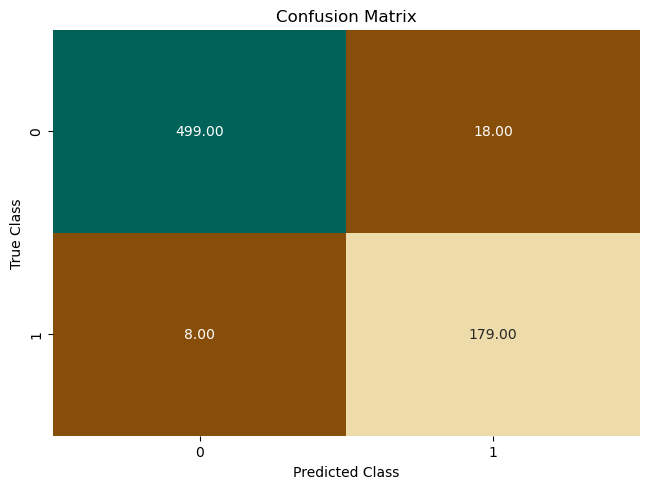

Sensitivity or TPR: 95.72192513368985%
Specificity or TNR: 96.5183752417795%
Precision: 90.86294416243655%
Negative Predictive Value: 98.42209072978304%
False Positive Rate: 3.481624758220503%
False Negative Rate: 4.27807486631016%
False Discovery Rate: 9.137055837563452%
Accuracy: 96.30681818181817%
Validation AUC 0.9612015018773467


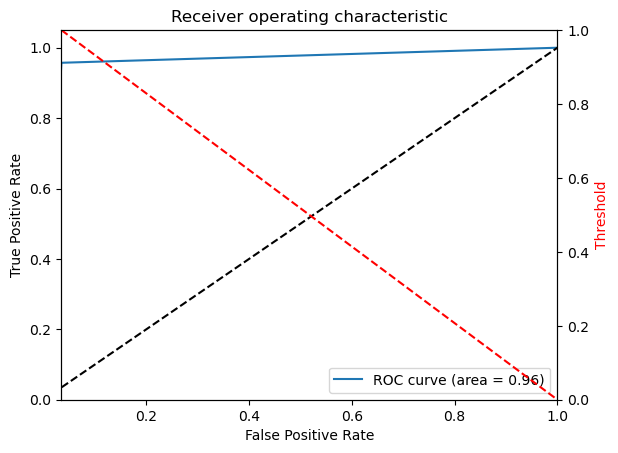

In [36]:
# Step 5: Evaluate model
print("\n===== Evaluating Best Model Performance =====")
plot_confusion_matrix(test_labels, predictions_binary)
plot_roc(test_labels, predictions_binary)

### Step 6: Model metrics

In [37]:
# Step 6: Evaluate with profit metrics
print("\n===== Evaluating Profit-Based Performance =====")
optimal_threshold, profit = evaluate_profit_metrics(test_labels, predictions_binary, predictions['Churn'])

# Show current threshold and profit
print(f"\n===== THRESHOLD OPTIMIZATION =====")
print(f"Current threshold: {best_threshold}")
print(f"Current profit: ${profit:.2f}")

# Store current profit for comparison
original_profit = profit


===== Evaluating Profit-Based Performance =====

===== Profit-Based Metrics =====
Total Profit: $385905.94
TP Profit (Saved Customers): $393826.47
FP Cost (Unnecessary Interventions): $7920.53
True Positives (Saved Customers): 179
False Positives (Unnecessary Interventions): 18
Optimal profit threshold: 0.1900, Profit: $388546.12

===== THRESHOLD OPTIMIZATION =====
Current threshold: 0.30000000000000004
Current profit: $388546.12


Found better threshold! Updating from 0.3000 to 0.1900
Best threshold saved to S3: s3://telco-churn-cp/best_threshold_new.pkl

===== Re-evaluating with optimal threshold =====


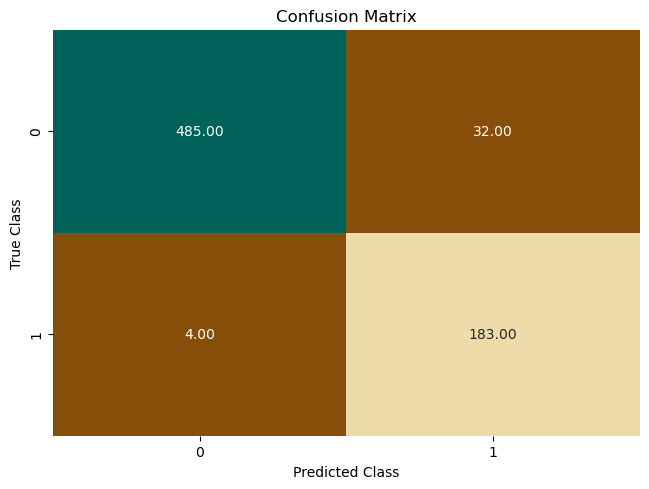

Sensitivity or TPR: 97.86096256684492%
Specificity or TNR: 93.81044487427465%
Precision: 85.11627906976744%
Negative Predictive Value: 99.18200408997954%
False Positive Rate: 6.189555125725339%
False Negative Rate: 2.13903743315508%
False Discovery Rate: 14.883720930232558%
Accuracy: 94.88636363636364%
Validation AUC 0.9583570372055978


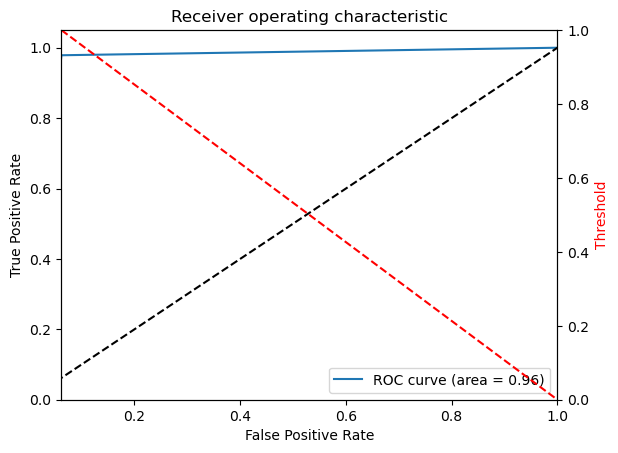


===== Profit-Based Metrics =====
Total Profit: $388546.12
TP Profit (Saved Customers): $402627.06
FP Cost (Unnecessary Interventions): $14080.95
True Positives (Saved Customers): 183
False Positives (Unnecessary Interventions): 32
Profit improvement: $0.00 (0.00%)
New profit: $388546.12


In [38]:
# If we found a better threshold, update and recompute binary predictions
if optimal_threshold is not None and abs(optimal_threshold - best_threshold) > 0.01:
    print(f"Found better threshold! Updating from {best_threshold:.4f} to {optimal_threshold:.4f}")
    best_threshold = optimal_threshold
    
    # Save the new best threshold
    s3_client = boto3.client('s3')
    try:
        # Save to S3 root
        s3_buffer = io.BytesIO()
        pickle.dump(best_threshold, s3_buffer)
        s3_client.put_object(
            Body=s3_buffer.getvalue(),
            Bucket=bucket,
            Key='best_threshold_new.pkl'
        )
        print(f"Best threshold saved to S3: s3://{bucket}/best_threshold_new.pkl")
    except Exception as e:
        print(f"Error saving threshold to S3: {e}")
        # Save locally as fallback
        with open('./best_threshold_new.pkl', 'wb') as f:
            pickle.dump(best_threshold, f)
        print("Best threshold saved locally as fallback")
    
    # Update binary predictions with new threshold
    predictions_binary = predictions['Churn'].apply(lambda x: 1 if x > best_threshold else 0)
    
    # Re-evaluate with new threshold
    print("\n===== Re-evaluating with optimal threshold =====")
    plot_confusion_matrix(test_labels, predictions_binary)
    plot_roc(test_labels, predictions_binary)
    _, new_profit = evaluate_profit_metrics(test_labels, predictions_binary)
    
    # Show profit improvement
    print(f"Profit improvement: ${new_profit - original_profit:.2f} ({((new_profit/original_profit)-1)*100:.2f}%)")
    print(f"New profit: ${new_profit:.2f}")

### Step 7: Model Metrics

In [39]:
# Calculate F1 score
f1 = calculate_f1_score(test_labels, predictions_binary)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9104



Precision-Recall Curve:


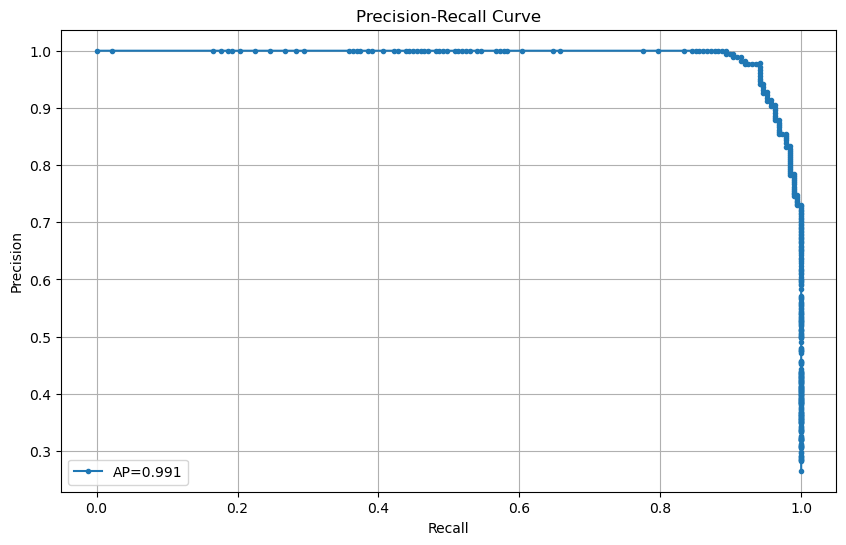

In [40]:
# Precision-Recall curve
print("\nPrecision-Recall Curve:")
precision, recall, pr_thresholds = plot_precision_recall_curve(test_labels, predictions['Churn'])

# Section 4: Cleanup and Save Predictions

To add testing steps for Round 2

### Step 1: Save predictions to local file and S3

In [41]:
# First, create a DataFrame with test data and predictions
results_df = test.copy()

# Reset index in predictions to make sure they align with test dataset
predictions_aligned = pd.DataFrame({'Churn': predictions['Churn'].values[:len(test)]})
predictions_binary_aligned = pd.Series(predictions_binary.values[:len(test)])

# Assign the aligned predictions to the results dataframe
results_df['prediction'] = predictions_aligned['Churn'].values
results_df['prediction_binary'] = predictions_binary_aligned.values

Testing Diagnostics for Debugging

In [42]:
# DIAGNOSTICS for Verify alignment succeeded
print(f"\nRESULTS DATAFRAME INFO:")
print(f"Shape: {results_df.shape}")
print(f"Prediction non-null count: {results_df['prediction'].count()}")
print(f"Binary prediction non-null count: {results_df['prediction_binary'].count()}")
print(f"First 5 rows of results:\n{results_df.head()}")


RESULTS DATAFRAME INFO:
Shape: (704, 32)
Prediction non-null count: 704
Binary prediction non-null count: 704
First 5 rows of results:
      Churn  ohe__Gender_Female  ohe__Gender_Male  contract_ord__Contract  \
5915      0                 1.0               0.0                1.467699   
6940      0                 0.0               1.0                0.289021   
1865      1                 0.0               1.0               -0.889657   
1227      0                 1.0               0.0                0.289021   
6368      0                 1.0               0.0                0.289021   

      internet_ord__Internet Type  service_ord__Service_Level  scaler__Age  \
5915                    -0.628053                    1.487710    -0.627478   
6940                    -1.451160                   -0.883133     0.029272   
1865                     1.018161                   -0.883133    -0.388660   
1227                    -0.628053                    0.302288    -0.866296   
6368       

In [43]:
# Save to local CSV
local_predictions_file = 'predictions_results.csv'
results_df.to_csv(local_predictions_file, index=False)
print(f"Predictions saved to local file: {local_predictions_file}")

Predictions saved to local file: predictions_results.csv


In [44]:
# Save to S3
s3_predictions_key = os.path.join(prefix, 'results/predictions_results.csv')
csv_buffer = io.StringIO()
results_df.to_csv(csv_buffer, index=False)
s3_resource.Bucket(bucket).Object(s3_predictions_key).put(Body=csv_buffer.getvalue())
print(f"Predictions saved to S3: s3://{bucket}/{s3_predictions_key}")

Predictions saved to S3: s3://telco-churn-cp/folders/results/predictions_results.csv


### Step 2: Lift and gain charts


Lift and Gain Charts:


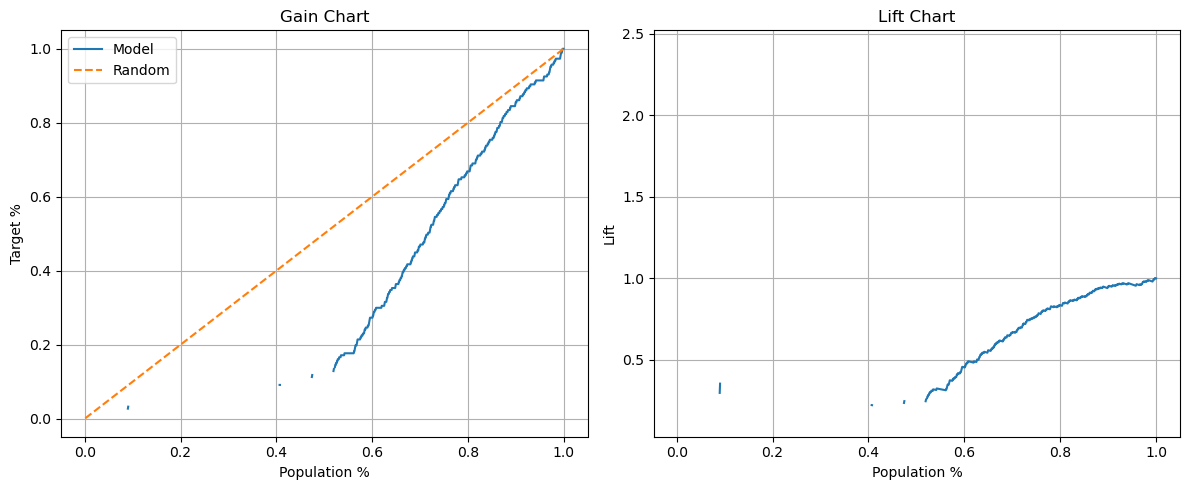

In [45]:
# Step 2: Lift and gain charts
print("\nLift and Gain Charts:")
plot_lift_gain_chart(test_labels, predictions['Churn'])

### Step 3: Get best params from tuning job to use locally

In [46]:
# Step 3: Get best params from tuning job to use locally
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # Changed to AUC
    'alpha': float(df_tuning_job_analytics.iloc[0]['alpha']),
    'min_child_weight': float(df_tuning_job_analytics.iloc[0]['min_child_weight']),
    'subsample': float(df_tuning_job_analytics.iloc[0]['subsample']),
    'eta': float(df_tuning_job_analytics.iloc[0]['eta']), 
    'num_round': int(df_tuning_job_analytics.iloc[0]['num_round'])
}

### Step 4: Save best parameters for future use

In [47]:
# Step 4: Save best parameters for future use
import json
# Save locally
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)
print("Best parameters saved to best_params.json")

Best parameters saved to best_params.json


In [48]:
# Save to S3
params_string = json.dumps(best_params, indent=4)
s3_resource.Bucket(bucket).Object(os.path.join(prefix, 'model/best_params.json')).put(Body=params_string)
print(f"Best parameters saved to s3://{bucket}/{prefix}/model/best_params.json")

Best parameters saved to s3://telco-churn-cp/folders/model/best_params.json


### Step 5: Feature importance analysis

In [49]:
#!pip install xgboost

In [50]:
# Step 5: Feature importance analysis
print("\nFeature Importance Analysis:")
X_test = test.drop('Churn', axis=1)
y_test = test['Churn']


Feature Importance Analysis:


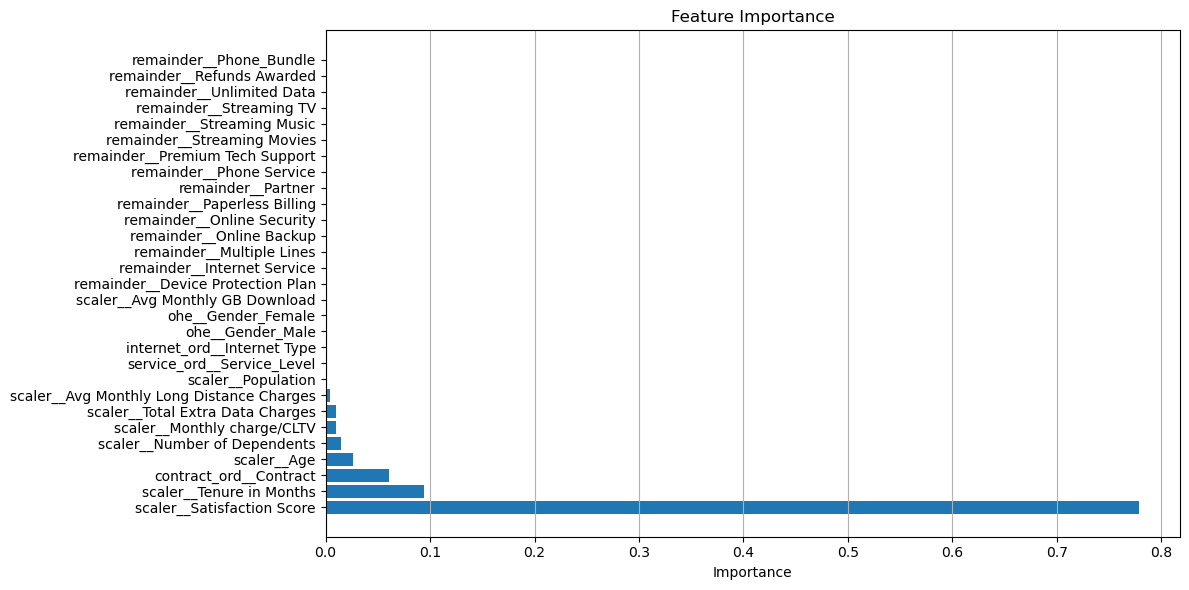

Top 5 important features:
                         Feature  Importance
10    scaler__Satisfaction Score    0.778940
11      scaler__Tenure in Months    0.094631
2         contract_ord__Contract    0.060457
5                    scaler__Age    0.026449
8   scaler__Number of Dependents    0.015164


In [51]:
feat_importance = plot_feature_importance(X_test, y_test, best_params)
print("Top 5 important features:")
print(feat_importance.head(5))

### Step 6: Partial dependence plots for top features


Partial Dependence Plots for Top Features:
Generating partial dependence plots for: ['scaler__Satisfaction Score', 'scaler__Tenure in Months', 'contract_ord__Contract']


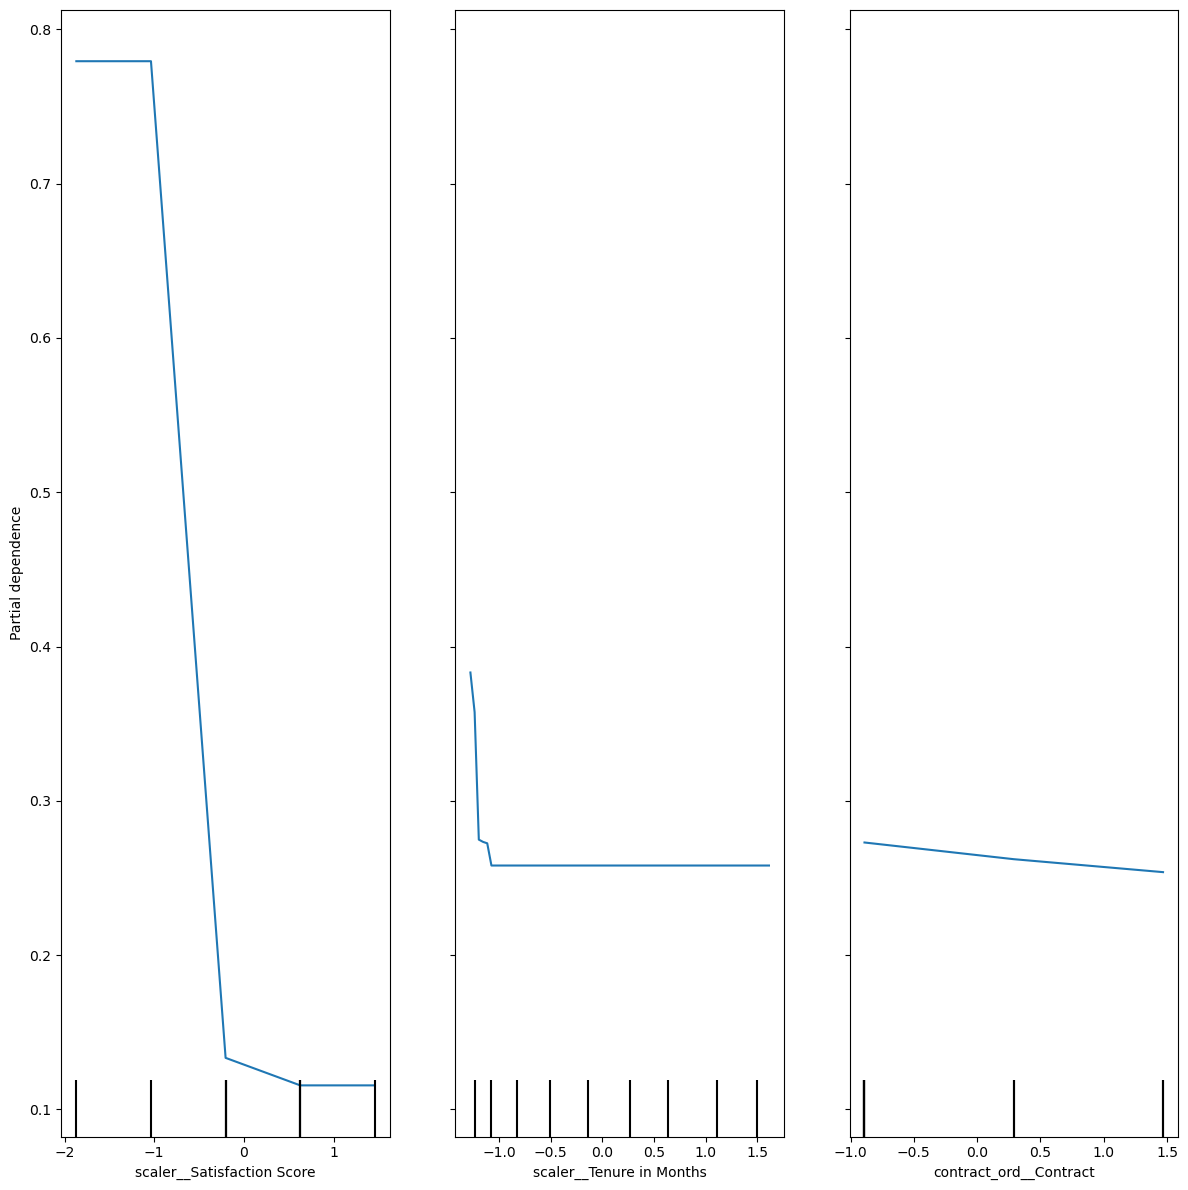

In [52]:
print("\nPartial Dependence Plots for Top Features:")
try:
    top_features = feat_importance['Feature'].head(3).tolist()
    plot_partial_dependence(X_test, y_test, best_params, features=top_features)
except Exception as e:
    print(f"Error in partial dependence plotting: {e}")
    print("Skipping partial dependence plots to continue with the rest of the analysis.")

### Step 7: Delete endpoint (only once)

In [53]:
# Step 7: Delete endpoint only once
print("\n===== Cleanup: Delete Endpoint =====")
try:
    predictor.delete_endpoint(delete_endpoint_config=True)
    print("Endpoint deleted successfully")
except Exception as e:
    print(f"Error deleting endpoint: {e}")
    endpoints = boto3.client('sagemaker').list_endpoints()
    print("Active endpoints that may need manual cleanup:")
    for endpoint in endpoints['Endpoints']:
        print(f"  - {endpoint['EndpointName']}")


===== Cleanup: Delete Endpoint =====


[04/07/25 00:25:15] INFO     Deleting endpoint configuration with name:                             ]8;id=317990;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=291396;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             sagemaker-xgboost-2025-04-07-00-21-15-358                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-04-07-00-21-15-358 ]8;id=660045;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=427022;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\

Endpoint deleted successfully


In [54]:
# Add at the end of the script (before cleanup)
print("\n===== FINAL RESULTS SUMMARY =====")
print(f"Best Threshold: {best_threshold}")
print(f"Final Profit: ${profit:.2f}")
print(f"AUC Score: {roc_auc_score(test_labels, predictions['Churn']):.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Top 3 Features: {top_features}")


===== FINAL RESULTS SUMMARY =====
Best Threshold: 0.19
Final Profit: $388546.12
AUC Score: 0.9959
F1 Score: 0.9104
Top 3 Features: ['scaler__Satisfaction Score', 'scaler__Tenure in Months', 'contract_ord__Contract']


### Step 8: Final cleanup check

In [55]:
# Step 8: Final cleanup check
try:
    endpoints = boto3.client('sagemaker').list_endpoints()
    if endpoints['Endpoints']:
        print("WARNING: You still have active endpoints that may incur charges:")
        for endpoint in endpoints['Endpoints']:
            print(f"  - {endpoint['EndpointName']}")
    else:
        print("No active endpoints found. Good job cleaning up!")
except Exception as e:
    print(f"Could not check for active endpoints: {e}")
    
print("Script execution completed")

  - sagemaker-xgboost-2025-04-07-00-09-03-539
Script execution completed
